Please upload Household Power Consumption dataset (CSV)


Saving household_power_consumption.csv to household_power_consumption.csv
Training ARIMA model...
Training Prophet model...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplxh4u774/0sq38jrc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplxh4u774/nx7p0p3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49621', 'data', 'file=/tmp/tmplxh4u774/0sq38jrc.json', 'init=/tmp/tmplxh4u774/nx7p0p3y.json', 'output', 'file=/tmp/tmplxh4u774/prophet_modeldv6wchqi/prophet_model-20250824103800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:38:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:38:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training XGBoost model...

Model Evaluation Results:
ARIMA -> MAE: 51.0378, RMSE: 67.9953
Prophet -> MAE: 53.3566, RMSE: 64.7954
XGBoost -> MAE: 49.1012, RMSE: 68.7643


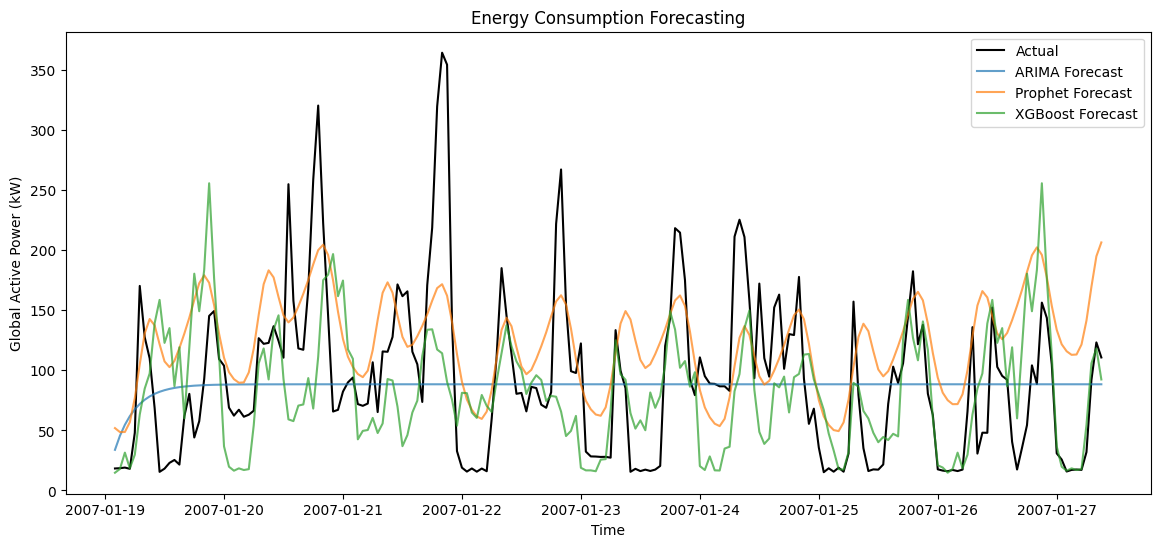

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from google.colab import files
import io

# ---------------------- Step 1: Upload dataset ----------------------
print("Please upload Household Power Consumption dataset (CSV)")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load first to inspect columns
df = pd.read_csv(io.BytesIO(uploaded[filename]), sep=',', low_memory=False)

# Handle datetime depending on format
if 'Date' in df.columns and 'Time' in df.columns:
    df = pd.read_csv(
        io.BytesIO(uploaded[filename]),
        sep=',',
        parse_dates={'datetime': ['Date', 'Time']},
        infer_datetime_format=True,
        low_memory=False,
        na_values=['?']
    )
elif 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
else:
    raise ValueError("Dataset must contain either ['Date','Time'] columns or a 'datetime' column")

# ---------------------- Step 2: Parse and Resample ----------------------
# Use Global_active_power as target
df = df[['datetime', 'Global_active_power']]
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')

# Resample hourly data
df_resampled = df.resample('H').mean()

# ---------------------- Step 3: Train-Test Split ----------------------
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled[:train_size], df_resampled[train_size:]

# ---------------------- Step 4: Feature Engineering for ML ----------------------
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    return df

train_feat = create_features(train)
test_feat = create_features(test)

X_train, y_train = train_feat.drop('Global_active_power', axis=1), train_feat['Global_active_power']
X_test, y_test = test_feat.drop('Global_active_power', axis=1), test_feat['Global_active_power']

# ---------------------- Step 5A: ARIMA Model ----------------------
print("Training ARIMA model...")
model_arima = ARIMA(train['Global_active_power'], order=(2,1,2))
model_arima_fit = model_arima.fit()
arima_pred = model_arima_fit.forecast(steps=len(test))

# ---------------------- Step 5B: Prophet Model ----------------------
print("Training Prophet model...")
prophet_df = train.reset_index()[['datetime', 'Global_active_power']]
prophet_df.columns = ['ds', 'y']

model_prophet = Prophet()
model_prophet.fit(prophet_df)

future = pd.DataFrame(test.index).reset_index(drop=True)
future.columns = ['ds']
forecast_prophet = model_prophet.predict(future)
prophet_pred = forecast_prophet['yhat'].values

# ---------------------- Step 5C: XGBoost Model ----------------------
print("Training XGBoost model...")
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# ---------------------- Step 6: Evaluation ----------------------
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse

print("\nModel Evaluation Results:")
mae_arima, rmse_arima = evaluate_model("ARIMA", test['Global_active_power'], arima_pred)
mae_prophet, rmse_prophet = evaluate_model("Prophet", test['Global_active_power'], prophet_pred)
mae_xgb, rmse_xgb = evaluate_model("XGBoost", y_test, xgb_pred)

# ---------------------- Step 7: Visualization ----------------------
plt.figure(figsize=(14,6))
plt.plot(test.index, test['Global_active_power'], label='Actual', color='black')
plt.plot(test.index, arima_pred, label='ARIMA Forecast', alpha=0.7)
plt.plot(test.index, prophet_pred, label='Prophet Forecast', alpha=0.7)
plt.plot(test.index, xgb_pred, label='XGBoost Forecast', alpha=0.7)
plt.title('Energy Consumption Forecasting')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()
